In [107]:
# Ignore  the warnings
import warnings
warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# data visualisation and manipulation
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns

# encodage des mots en Int
from numpy import array
from numpy import argmax
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
 
#configure
# sets matplotlib to inline and displays graphs below the corressponding cell.
%matplotlib inline  
style.use('fivethirtyeight')
sns.set(style='whitegrid',color_codes=True)

#model selection
from sklearn.decomposition import NMF
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score,precision_score,recall_score,confusion_matrix,roc_curve,roc_auc_score
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

#preprocess.
from keras.preprocessing.image import ImageDataGenerator

#dl libraraies
import keras
from keras import backend as K
from keras.models import Sequential
from keras.layers import Dense , merge
from keras.optimizers import Adam,SGD,Adagrad,Adadelta,RMSprop
from keras.utils import to_categorical
from keras.utils.vis_utils import model_to_dot
from keras.callbacks import ReduceLROnPlateau


from keras.layers.merge import dot
from keras.models import Model


# specifically for deeplearning.
from keras.layers import Dropout, Flatten,Activation,Input,Embedding
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization
import tensorflow as tf
import random as rn
from IPython.display import SVG
 
# specifically for manipulating zipped images and getting numpy arrays of pixel values of images.
#import cv2 # erreur import
import numpy as np  
from tqdm import tqdm
import os                   
from random import shuffle  
from zipfile import ZipFile
from PIL import Image

#TL pecific modules
from keras.applications.vgg16 import VGG16

# pour parser le fichier train.json
import json

In [108]:
with open('train.json', 'r') as f:
    datas = json.load(f) # id, cuisine, ingredients[]

csv = []
occurence = dict()
for data in datas:
    for ingredient in data['ingredients']:
        cuisine = data['cuisine']
        
        # Ajout de la ligne id-cuisine-ingredient
        tmp = dict()
        tmp['id'] = str(data['id'])
        tmp['cuisine'] = cuisine
        tmp['ingredient'] = ingredient
        csv.append(tmp)
        
        # Comptage de l'occurence
        if not cuisine in occurence:
            occurence[cuisine] = dict()
        if not ingredient in occurence[cuisine]:
            occurence[cuisine][ingredient] = 0
        occurence[cuisine][ingredient] += 1

# Ajout des occurences dans le CSV
for ligne in csv:
    cuisine = ligne['cuisine']
    ingredient = ligne['ingredient']
    ligne['occurence'] = occurence[cuisine][ingredient]


# $ingredients contient tous les ingredients possibles


train = pd.DataFrame(csv)

In [109]:
df = train.copy()

In [110]:
df.head()

,cuisine,id,ingredient,occurence
0,greek,10259,romaine lettuce,39
1,greek,10259,black olives,31
2,greek,10259,grape tomatoes,26
3,greek,10259,garlic,216
4,greek,10259,pepper,203


In [111]:
# Encodage des valeurs

#le_cuisine = LabelEncoder()
#le_ingredient = LabelEncoder()

#df['cuisine'] = le_cuisine.fit_transform(df['cuisine'])
#df['ingredient'] = le_ingredient.fit_transform(df['ingredient'])

# Pour inverser l'encodage il faudra utiliser ces deux lignes :
#df['cuisine'] = le_cuisine.inverse_transform(df['cuisine'])
#df['ingredient'] = le_ingredient.inverse_transform(df['ingredient'])

#df.head()

In [112]:
df['cuisine'].unique()

array(['greek', 'southern_us', 'filipino', 'indian', 'jamaican',
       'spanish', 'italian', 'mexican', 'chinese', 'british', 'thai',
       'vietnamese', 'cajun_creole', 'brazilian', 'french', 'japanese',
       'irish', 'korean', 'moroccan', 'russian'], dtype=object)

In [113]:
len(df['cuisine'].unique())

20

In [114]:
df['ingredient'].unique()

array(['romaine lettuce', 'black olives', 'grape tomatoes', ...,
       'lop chong', 'tomato garlic pasta sauce',
       'crushed cheese crackers'], dtype=object)

In [115]:
len(df['ingredient'].unique())

6714

In [116]:
# Pour verifier que toutes les donnees sont bonnes
df['cuisine'].isnull().sum()

0

In [117]:
# Pour verifier que toutes les donnees sont bonnes
df['ingredient'].isnull().sum()

0

In [118]:
# Creation de la matrix

index = list(df['cuisine'].unique())
columns = list(df['ingredient'].unique())
index = sorted(index)
columns = sorted(columns)

print(index)
print(columns)
 
util_df = pd.pivot_table(data = df, values = 'occurence', index = 'cuisine', columns = 'ingredient')

['brazilian', 'british', 'cajun_creole', 'chinese', 'filipino', 'french', 'greek', 'indian', 'irish', 'italian', 'jamaican', 'japanese', 'korean', 'mexican', 'moroccan', 'russian', 'southern_us', 'spanish', 'thai', 'vietnamese']
['(    oz.) tomato sauce', '(   oz.) tomato paste', '(10 oz.) frozen chopped spinach', '(10 oz.) frozen chopped spinach, thawed and squeezed dry', '(14 oz.) sweetened condensed milk', '(14.5 oz.) diced tomatoes', '(15 oz.) refried beans', '1% low-fat buttermilk', '1% low-fat chocolate milk', '1% low-fat cottage cheese', '1% low-fat milk', '2 1/2 to 3 lb. chicken, cut into serving pieces', '2% low fat cheddar chees', '2% low-fat cottage cheese', '2% lowfat greek yogurt', '2% milk shredded mozzarella cheese', '2% reduced-fat milk', '25% less sodium chicken broth', '33% less sodium cooked deli ham', '33% less sodium cooked ham', '33% less sodium ham', '33% less sodium smoked fully cooked ham', '40% less sodium taco seasoning', '40% less sodium taco seasoning mix',

In [119]:
util_df

ingredient,( oz.) tomato sauce,( oz.) tomato paste,(10 oz.) frozen chopped spinach,"(10 oz.) frozen chopped spinach, thawed and squeezed dry",(14 oz.) sweetened condensed milk,(14.5 oz.) diced tomatoes,(15 oz.) refried beans,1% low-fat buttermilk,1% low-fat chocolate milk,1% low-fat cottage cheese,...,yukon gold potatoes,yuzu,yuzu juice,za'atar,zest,zesty italian dressing,zinfandel,ziti,zucchini,zucchini blossoms
cuisine,,,,,,,,,,,,,,,,,,,,,
brazilian,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN
british,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN
cajun_creole,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13.0,NaN
chinese,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,30.0,NaN
filipino,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.0,NaN
french,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,1.0,...,41.0,NaN,NaN,NaN,NaN,NaN,5.0,NaN,86.0,NaN
greek,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,4.0,NaN,NaN,NaN,2.0,1.0,2.0,3.0,47.0,NaN
indian,NaN,2.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,...,27.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,42.0,NaN
irish,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,...,24.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN


In [120]:
util_df = util_df.fillna(0)
util_df

ingredient,( oz.) tomato sauce,( oz.) tomato paste,(10 oz.) frozen chopped spinach,"(10 oz.) frozen chopped spinach, thawed and squeezed dry",(14 oz.) sweetened condensed milk,(14.5 oz.) diced tomatoes,(15 oz.) refried beans,1% low-fat buttermilk,1% low-fat chocolate milk,1% low-fat cottage cheese,...,yukon gold potatoes,yuzu,yuzu juice,za'atar,zest,zesty italian dressing,zinfandel,ziti,zucchini,zucchini blossoms
cuisine,,,,,,,,,,,,,,,,,,,,,
brazilian,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0
british,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0
cajun_creole,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,13.0,0.0
chinese,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,30.0,0.0
filipino,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.0,0.0
french,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,...,41.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,86.0,0.0
greek,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,4.0,0.0,0.0,0.0,2.0,1.0,2.0,3.0,47.0,0.0
indian,0.0,2.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,27.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,42.0,0.0
irish,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,...,24.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0


In [121]:
X = util_df
model = NMF(n_components=6, init='random', random_state=0)
W = model.fit_transform(X)
H = model.components_

In [122]:
W = pd.DataFrame(W, index, ["type_" + str(i+1) for i in range(len(W[0]))])
H = pd.DataFrame(H, ["type_" + str(i+1) for i in range(len(H))], columns)

In [123]:
print(W)
print(H)

                type_1     type_2    type_3     type_4    type_5     type_6
brazilian     0.186564   0.495214  0.067933   0.172330  0.081040   0.171188
british       0.000000   0.147600  0.000000   0.000000  0.052116   2.095633
cajun_creole  4.950307   0.143910  0.000000   0.000000  0.000000   0.152340
chinese       0.176313   0.000000  6.719613   0.000000  0.000000   0.303791
filipino      0.519723   0.387809  0.842869   0.054473  0.244489   0.235220
french        0.000000   4.757073  0.092202   0.000000  0.040012   4.025797
greek         0.240206   3.979688  0.000000   0.193335  0.091662   0.000000
indian        0.000000   0.000000  0.000000   0.000000  4.052202   0.397178
irish         0.121901   0.182105  0.000000   0.000000  0.054584   1.641129
italian       0.102237  32.127643  0.020049   0.091710  0.000000   0.348192
jamaican      0.506193   0.153594  0.293126   0.134562  0.152411   0.389177
japanese      0.000000   0.000000  2.082001   0.000000  0.155227   0.616897
korean      

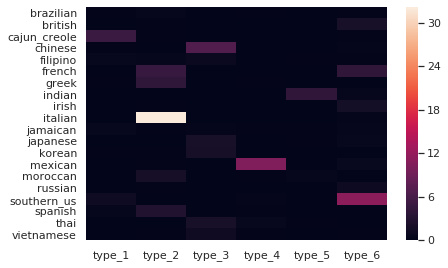

In [124]:
ax = sns.heatmap(W)

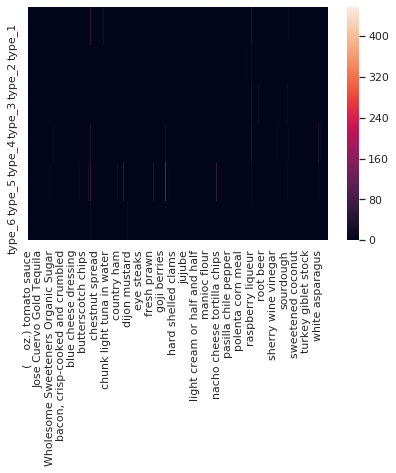

In [125]:
ay = sns.heatmap(H)

In [129]:
print(index) # cuisines
print(columns) # ingrédients

['brazilian', 'british', 'cajun_creole', 'chinese', 'filipino', 'french', 'greek', 'indian', 'irish', 'italian', 'jamaican', 'japanese', 'korean', 'mexican', 'moroccan', 'russian', 'southern_us', 'spanish', 'thai', 'vietnamese']
['(    oz.) tomato sauce', '(   oz.) tomato paste', '(10 oz.) frozen chopped spinach', '(10 oz.) frozen chopped spinach, thawed and squeezed dry', '(14 oz.) sweetened condensed milk', '(14.5 oz.) diced tomatoes', '(15 oz.) refried beans', '1% low-fat buttermilk', '1% low-fat chocolate milk', '1% low-fat cottage cheese', '1% low-fat milk', '2 1/2 to 3 lb. chicken, cut into serving pieces', '2% low fat cheddar chees', '2% low-fat cottage cheese', '2% lowfat greek yogurt', '2% milk shredded mozzarella cheese', '2% reduced-fat milk', '25% less sodium chicken broth', '33% less sodium cooked deli ham', '33% less sodium cooked ham', '33% less sodium ham', '33% less sodium smoked fully cooked ham', '40% less sodium taco seasoning', '40% less sodium taco seasoning mix',

In [139]:
ingr = columns[42]
ingr

'BACARDI® Mixers Margarita Mix'

In [140]:
tab_ingr1 = H[ingr]
tab_ingr2 = H[columns[143]]
print(tab_ingr1, tab_ingr2)
test = tab_ingr1 + tab_ingr2
test

type_1    0.000000
type_2    0.000000
type_3    0.000350
type_4    0.000000
type_5    0.003062
type_6    0.006961
Name: BACARDI® Mixers Margarita Mix, dtype: float64 type_1    0.000000
type_2    0.000000
type_3    0.034929
type_4    0.004460
type_5    0.011162
type_6    0.000000
Name: Flora pro.activ, dtype: float64


type_1    0.000000
type_2    0.000000
type_3    0.035278
type_4    0.004460
type_5    0.014224
type_6    0.006961
dtype: float64

In [141]:
print(tab_ingr1, tab_ingr1/2)

type_1    0.000000
type_2    0.000000
type_3    0.000350
type_4    0.000000
type_5    0.003062
type_6    0.006961
Name: BACARDI® Mixers Margarita Mix, dtype: float64 type_1    0.000000
type_2    0.000000
type_3    0.000175
type_4    0.000000
type_5    0.001531
type_6    0.003480
Name: BACARDI® Mixers Margarita Mix, dtype: float64


In [161]:
def avg_recette(tab):
    sortie = pd.DataFrame([], )
    for ingr in tab:
        sortie += ingr
    sortie /= len(tab)
    return sortie



In [160]:
tab = [tab_ingr1, tab_ingr2]
new_tab = avg_recette(tab)
print(new_tab)

TypeError: Index(...) must be called with a collection of some kind, 'test' was passed